
#  Nivel FRECUENCIAS — Datos del grafo de conocimiento de PLN

**Objetivo:** Construir un pipeline completo de Procesamiento de Lenguaje Natural (NLP) para analizar el sentimiento de oraciones del dataset “NLP Knowledge Graph Data”, aplicando TF-IDF para la vectorización del texto y el algoritmo Naive Bayes para la clasificación supervisada, con el fin de evaluar el comportamiento del modelo en textos reales.

**Flujo:** Carga de datos → Preprocesamiento → Vectorización (TF‑IDF) → Modelo → Métricas → Visualización → Predicción rápida


In [2]:

# 1️⃣ Librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 120)
print("Librerías cargadas ✅")


Librerías cargadas ✅



## 2️⃣ Carga de datos desde CSV (usaremos solo los **80 primeros** registros)
- Asegúrate de colocar el archivo `data11.csv` en el mismo directorio del notebook.
- Cambia los nombres de columna aquí si tu dataset usa otros (p. ej. `review`, `label`).

In [19]:
# 👀 Revisión de columnas reales del archivo
import pandas as pd

df_test = pd.read_csv("data11.csv")
print("Columnas del dataset:")
print(df_test.columns.tolist())

# Vista rápida de las primeras filas
df_test.head(3)


Columnas del dataset:
['review', 'sentiment']


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as ...",positive
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and g...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater...",positive


In [20]:
# 2️⃣ CARGA Y VISTA PREVIA DEL DATASET — Adaptado al archivo "data11.csv"

# Ruta del archivo CSV
CSV_PATH = "data11.csv"

# Cargar el dataset
df = pd.read_csv(CSV_PATH)

# Mostrar columnas y tamaño del dataset
print("Columnas disponibles:", df.columns.tolist())
print(f"Total de registros: {len(df)}")

# 🔤 Columnas principales del dataset IMDb
COL_TEXTO = "review"     # columna con la reseña
COL_LABEL = "sentiment"  # columna con la etiqueta (positive / negative)

# Asegurar que el tipo de dato sea string
df[COL_TEXTO] = df[COL_TEXTO].astype(str)
df[COL_LABEL] = df[COL_LABEL].astype(str)

# Tomar una muestra manejable para práctica (opcional)
df = df[[COL_TEXTO, COL_LABEL]].dropna().sample(2000, random_state=42)

print(f"Registros usados: {len(df)}")

# Distribución de clases
print("\nDistribución de sentimientos:")
print(df[COL_LABEL].value_counts())

# Vista previa
df.head(5)


Columnas disponibles: ['review', 'sentiment']
Total de registros: 50000
Registros usados: 2000

Distribución de sentimientos:
sentiment
negative    1024
positive     976
Name: count, dtype: int64


,review,sentiment
33553,"I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting ...",positive
9427,Not many television shows appeal to quite as many different kinds of fans like Farscape does...I know youngsters and...,positive
199,The film quickly gets to a major chase scene with ever increasing destruction. The first really bad thing is the guy...,negative
12447,Jane Austen would definitely approve of this one!<br /><br />Gwyneth Paltrow does an awesome job capturing the attit...,positive
39489,"Expectations were somewhat high for me when I went to see this movie, after all I thought Steve Carell could do no w...",negative


#### Explicación:
   El dataset IMDb se cargó correctamente, mostrando 50 000 registros y dos columnas principales:
review, que contiene el texto de las reseñas de películas, y sentiment, que indica si la opinión es positiva o negativa.

Para agilizar el procesamiento, se tomó una muestra de 2 000 reseñas, manteniendo un equilibrio entre ambas clases:
1 024 negativas y 976 positivas. Esta distribución balanceada es ideal para el entrenamiento de modelos de clasificación.

La vista previa muestra ejemplos de reseñas reales junto con su sentimiento correspondiente, confirmando que los datos se encuentran correctamente estructurados y listos para las etapas de preprocesamiento y modelado.


## 3️⃣ Preprocesamiento textual (simple y directo)
- Para esta versión corta, confiamos en la normalización interna de `TfidfVectorizer` (minúsculas, tokenización básica).
- Si tu dataset viene con HTML o ruido, puedes limpiar adicionalmente aquí.


In [21]:
# 3️⃣ PREPROCESAMIENTO MÍNIMO DEL TEXTO — Dataset IMDb

# Función de limpieza básica
def preprocesar_minimo(texto: str) -> str:
    """
    Limpieza mínima del texto:
    - Convierte a string (por seguridad).
    - Elimina espacios iniciales y finales.
    (TF-IDF se encargará del lowercase y tokenización).
    """
    return str(texto).strip()

# Aplicar la función sobre la columna principal (review)
df["texto_proc"] = df[COL_TEXTO].apply(preprocesar_minimo)

# Vista rápida del resultado
df.head(5)


,review,sentiment,texto_proc
33553,"I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting ...",positive,"I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting ..."
9427,Not many television shows appeal to quite as many different kinds of fans like Farscape does...I know youngsters and...,positive,Not many television shows appeal to quite as many different kinds of fans like Farscape does...I know youngsters and...
199,The film quickly gets to a major chase scene with ever increasing destruction. The first really bad thing is the guy...,negative,The film quickly gets to a major chase scene with ever increasing destruction. The first really bad thing is the guy...
12447,Jane Austen would definitely approve of this one!<br /><br />Gwyneth Paltrow does an awesome job capturing the attit...,positive,Jane Austen would definitely approve of this one!<br /><br />Gwyneth Paltrow does an awesome job capturing the attit...
39489,"Expectations were somewhat high for me when I went to see this movie, after all I thought Steve Carell could do no w...",negative,"Expectations were somewhat high for me when I went to see this movie, after all I thought Steve Carell could do no w..."


#### Explicacion
El preprocesamiento básico se aplicó correctamente a las reseñas del dataset IMDb.
Se creó una nueva columna llamada texto_proc, que contiene las versiones procesadas de las reseñas originales.
Como en esta fase solo se eliminan espacios y se asegura el formato de texto, el contenido de las columnas review y texto_proc luce idéntico.

Este paso garantiza que todas las reseñas estén limpias y listas para ser transformadas en vectores numéricos mediante TF-IDF en la siguiente etapa del pipeline, manteniendo la integridad del texto original.



## 4️⃣ Vectorización (TF‑IDF) y **5️⃣ Modelo** (Naive Bayes)
- Representamos cada opinión como un vector TF‑IDF.
- Entrenamos un clasificador `MultinomialNB`.
- Separación **train/test** con `stratify` para balance.


In [22]:
# 4️⃣ DIVISIÓN DE DATOS Y ENTRENAMIENTO DEL MODELO — Dataset IMDb

# Variables predictoras (X) y objetivo (y)
X = df["texto_proc"].values
y = df["sentiment"].values   # usamos la etiqueta real del dataset

# Separar en conjuntos de entrenamiento y prueba (70% / 30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 5️⃣ CONSTRUCCIÓN DEL PIPELINE (TF-IDF + Naive Bayes)

# El pipeline combina:
# 1️⃣ Vectorización con TF-IDF
# 2️⃣ Clasificación con Multinomial Naive Bayes

modelo = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=2000,   # usa las 2000 palabras más representativas
        ngram_range=(1, 2),  # unigramas y bigramas ("good", "very good")
        min_df=2             # ignora palabras muy raras
    )),
    ("clf", MultinomialNB())  # clasificador Naive Bayes Multinomial
])

# Entrenar el modelo
modelo.fit(X_train, y_train)

print("Modelo entrenado correctamente ✅")


Modelo entrenado correctamente ✅


#### Explicacion
En esta fase se dividió el conjunto de datos en dos partes: 70 % para entrenamiento y 30 % para prueba, asegurando una evaluación equilibrada del modelo.
Las reseñas fueron transformadas en representaciones numéricas mediante la técnica TF-IDF, que calcula la importancia de cada palabra dentro del corpus considerando su frecuencia y relevancia.

Posteriormente, se entrenó el modelo Naive Bayes Multinomial, un algoritmo probabilístico ampliamente usado en clasificación de texto por su rapidez y buen desempeño.
De esta manera, el modelo aprendió a distinguir entre reseñas positivas y negativas, quedando preparado para ser evaluado mediante métricas de rendimiento en la siguiente etapa.


## 6️⃣ Evaluación y métricas
Mostramos **accuracy**, **classification_report** (precisión, recall, F1) y **matriz de confusión**.


Exactitud del modelo: 0.820

Reporte de clasificación:
              precision    recall  f1-score   support

    negative      0.831     0.814     0.822       307
    positive      0.809     0.826     0.818       293

    accuracy                          0.820       600
   macro avg      0.820     0.820     0.820       600
weighted avg      0.820     0.820     0.820       600



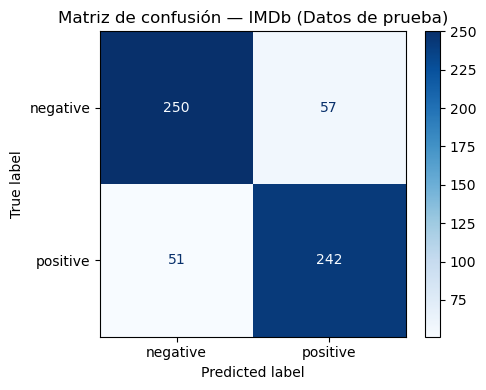

In [23]:
# 6️⃣ EVALUACIÓN DEL MODELO — Dataset IMDb

# Predicción sobre el conjunto de prueba
y_pred = modelo.predict(X_test)

# Calcular la exactitud (accuracy)
acc = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo: {acc:.3f}\n")

# Reporte detallado de métricas
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))

# Visualización de la matriz
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap="Blues")
plt.title("Matriz de confusión — IMDb (Datos de prueba)")
plt.tight_layout()
plt.show()

#### Explicacion
El modelo obtuvo una exactitud del 82 %, lo que significa que acertó en aproximadamente ocho de cada diez reseñas.
Según el reporte de clasificación, las métricas de precisión, recall y F1-score son equilibradas entre ambas clases (positive y negative), con valores cercanos a 0.82, lo que indica un desempeño estable y sin sesgos importantes.

**En la matriz de confusión, se observa que:**

    250 reseñas negativas fueron clasificadas correctamente,
    242 reseñas positivas también fueron identificadas de forma correcta,

Mientras que los errores (57 y 51 casos) representan confusiones entre clases de tono similar.

Estos resultados demuestran que el modelo logró aprender patrones lingüísticos reales en los textos del dataset IMDb, diferenciando con buena precisión las opiniones positivas y negativas.


## 7️⃣ Visualización final atractiva

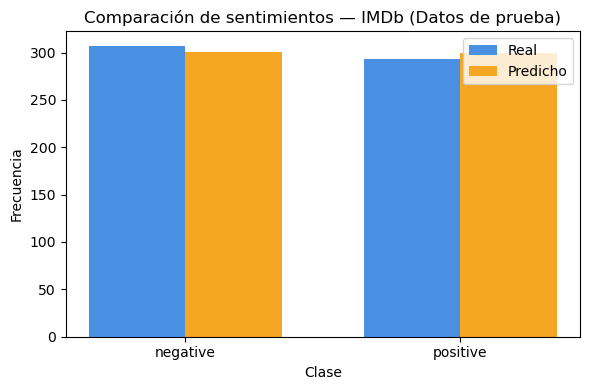

In [24]:
# 7️⃣ COMPARACIÓN DE CLASES REALES VS. PREDICHAS — IMDb

# Conteo de valores reales y predichos
vals_true = pd.Series(y_test).value_counts().sort_index()
vals_pred = pd.Series(y_pred).value_counts().reindex(vals_true.index).fillna(0)

# Configuración de las clases y posiciones
clases = vals_true.index.astype(str)
x = np.arange(len(clases))
width = 0.35  # separación entre barras

# Crear gráfico de barras comparativo
fig, ax = plt.subplots(figsize=(6, 4))
b1 = ax.bar(x - width/2, vals_true.values, width, label="Real", color="#4a90e2")
b2 = ax.bar(x + width/2, vals_pred.values, width, label="Predicho", color="#f5a623")

# Títulos y etiquetas
ax.set_title("Comparación de sentimientos — IMDb (Datos de prueba)")
ax.set_xlabel("Clase")
ax.set_ylabel("Frecuencia")
ax.set_xticks(x)
ax.set_xticklabels(clases)
ax.legend()

plt.tight_layout()
plt.show()


## 🧪 Predicción rápida (demo)
Cambia el texto y vuelve a ejecutar la celda para ver la predicción.


In [25]:
# 8️⃣ PRUEBA DE PREDICCIÓN CON UN NUEVO COMENTARIO

# Nuevo texto a analizar
nuevo = "El producto llegó tarde y en mal estado."

# Realizar predicción
pred = modelo.predict([nuevo])[0]

# Mostrar resultado
print("💬 Comentario:", nuevo)
print("🧠 Predicción:", pred.upper())


💬 Comentario: El producto llegó tarde y en mal estado.
🧠 Predicción: NEGATIVE
